# Growing Conditional Neural Cellular Automata

## Import

In [2]:
import jax
import jax.numpy as jnp
import mediapy
import optax
from cax.core.ca import CA
from cax.core.perceive.depthwise_conv_perceive import DepthwiseConvPerceive
from cax.core.perceive.kernels import grad_kernel, identity_kernel
from cax.core.state import state_from_rgba_to_rgb, state_to_rgba
from cax.core.update.nca_update import NCAUpdate
from cax.nn.pool import Pool
from cax.utils.image import get_emoji
from flax import nnx

## Configuration

In [ ]:
seed = 0

channel_size = 32
num_kernels = 3
hidden_size = 256
cell_dropout_rate = 0.5

pool_size = 1_024
batch_size = 8
num_steps = 128
learning_rate = 2e-3

emojis = "🐶🐱🐭🐹🐰🦊🐻🐼"
target_size = 40
target_padding = 16

key = jax.random.PRNGKey(seed)
rngs = nnx.Rngs(seed)

## Dataset

,,,,,,,

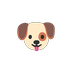
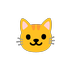
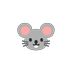
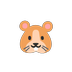
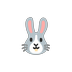
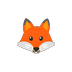
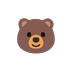
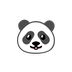

In [4]:
targets = jnp.array([get_emoji(emoji, size=target_size, padding=target_padding) for emoji in emojis])
targets_enc = jnp.eye(targets.shape[0])

mediapy.show_images(targets)

## Init state

In [4]:
def init_state(key):
	state_shape = targets.shape[1:3] + (channel_size,)

	state = jnp.zeros(state_shape)
	mid = (size // 2 for size in state_shape[:-1])
	state = state.at[*mid, -1].set(1.0)

	target_index = jax.random.choice(key, targets.shape[0])
	return state, target_index

## Model

In [6]:
perceive = DepthwiseConvPerceive(channel_size, rngs)
update = NCAUpdate(
	channel_size, len(emojis) + num_kernels * channel_size, (hidden_size,), rngs, cell_dropout_rate=cell_dropout_rate
)

In [7]:
kernel = jnp.concatenate([identity_kernel(ndim=2), grad_kernel(ndim=2)], axis=-1)
kernel = jnp.expand_dims(jnp.concatenate([kernel] * channel_size, axis=-1), axis=-2)
perceive.depthwise_conv.kernel = nnx.Param(kernel)

In [8]:
ca = CA(perceive, update)

In [9]:
params = nnx.state(ca, nnx.Param)
print("Number of params:", jax.tree_util.tree_reduce(lambda x, y: x + y.size, params, 0))

Number of params: 35968


## Train

### Pool

In [10]:
key, subkey = jax.random.split(key)

keys = jax.random.split(subkey, pool_size)
state, target_index = jax.vmap(lambda key: init_state(key))(keys)

pool = Pool.create(state=state, target_index=target_index)

### Optimizer

In [11]:
lr_sched = optax.linear_schedule(init_value=learning_rate, end_value=0.1 * learning_rate, transition_steps=2_000)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),
)

update_params = nnx.All(nnx.Param, nnx.PathContains("update"))
optimizer = nnx.Optimizer(ca, optimizer, wrt=update_params)

### Loss

In [12]:
def mse(state, target):
	return jnp.mean(jnp.square(state_to_rgba(state) - target))

In [13]:
@nnx.jit
def loss_fn(ca, state, target_enc, target, key):
	state = nnx.vmap(lambda state, input: ca(state, input, num_steps=num_steps, all_steps=True))(state, target_enc)
	index = jax.random.randint(key, (state.shape[0],), num_steps // 2, num_steps)
	state = state[jnp.arange(state.shape[0]), index]
	loss = mse(state, target)
	return loss, state

### Train step

In [14]:
@nnx.jit
def train_step(ca, optimizer, pool, key):
	sample_key, init_state_key, loss_key = jax.random.split(key, 3)

	# Sample from pool
	pool_index, sample = pool.sample(sample_key, sample_size=batch_size)
	current_state = sample["state"]
	current_target_index = sample["target_index"]
	current_target = targets[current_target_index]

	# Sort by descending loss
	sort_index = jnp.argsort(jax.vmap(mse)(current_state, current_target), descending=True)
	pool_index = pool_index[sort_index]
	current_state = current_state[sort_index]
	current_target_index = current_target_index[sort_index]

	# Sample a new target to replace the worst
	new_state, new_target_index = init_state(init_state_key)
	current_state = current_state.at[0].set(new_state)
	current_target_index = current_target_index.at[0].set(new_target_index)
	current_target = targets[current_target_index]
	current_target_enc = targets_enc[current_target_index]

	(loss, current_state), grad = nnx.value_and_grad(loss_fn, has_aux=True, argnums=nnx.DiffState(0, update_params))(
		ca, current_state, current_target_enc, current_target, loss_key
	)
	optimizer.update(grad)

	pool = pool.add(pool_index, state=current_state, target_index=current_target_index)
	return loss, pool

### Main loop

In [ ]:
for i in range(8_192):
	key, subkey = jax.random.split(key)
	loss, pool = train_step(ca, optimizer, pool, subkey)
	if i % 128 == 0:
		print(f"Step {i}: loss = {loss}")

## Visualize

,,,,,,,

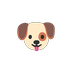
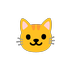
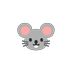
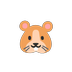
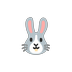
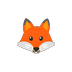
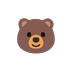
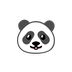

In [25]:
mediapy.show_images(targets)

,,,,,,,

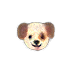
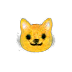
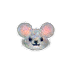
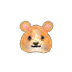
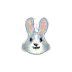
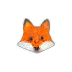
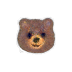
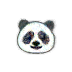

In [26]:
key, subkey = jax.random.split(key)

state, _ = init_state(subkey)
state = nnx.vmap(lambda input: ca(state, input, num_steps=2 * num_steps))(targets_enc)

mediapy.show_images(state_to_rgba(state))

,,,,,,,

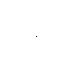
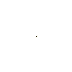
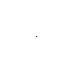
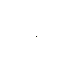
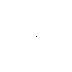
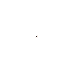
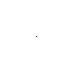
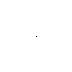

In [27]:
key, subkey = jax.random.split(key)

state, _ = init_state(subkey)
state = nnx.vmap(lambda input: ca(state, input, num_steps=2 * num_steps, all_steps=True))(targets_enc)

mediapy.show_videos(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

### Interpolation

#### dog-panda

""

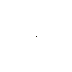

In [28]:
x = jnp.array([0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state = ca(state, x, num_steps=2 * num_steps, all_steps=True)

mediapy.show_video(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

#### fox-panda

""

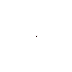

In [29]:
x = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state = ca(state, x, num_steps=2 * num_steps, all_steps=True)

mediapy.show_video(state_from_rgba_to_rgb(state), width=128, height=128, codec="gif")

#### cat-panda

,,,,,,,,,

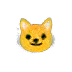
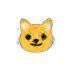
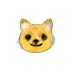
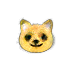
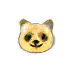
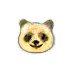
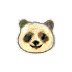
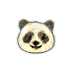
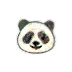
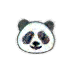

In [30]:
alphas = jnp.linspace(0.0, 1.0, 10)

target_enc_1 = targets_enc[1]
target_enc_2 = targets_enc[7]

target_encs = jnp.array([(1.0 - alpha) * target_enc_1 + alpha * target_enc_2 for alpha in alphas])

key, subkey = jax.random.split(key)
state, _ = init_state(subkey)

state = nnx.vmap(lambda x: ca(state, x, num_steps=2 * num_steps))(target_encs)

mediapy.show_images(state_to_rgba(state))